In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 26.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 70 kB 9.7 MB/s 
  Created wheel for pycuda: filename=pycuda-2022.1-cp37-cp37m-linux_x86_64.whl size=629484 sha256=b35288a2f89b5ba851ab14c2057ab97a95129866b78a67c0a2682723db2f8873
  Stored in directory: /root/.cache/pip/wheels/17/53/c9/caa05618e686df51f017d8a9923f38d915ce31df67ab6628e6
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=77f1f139303e46c0212cc8721d1b23a86e3386562a485e60b72d5a775fd4b541
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
Successfully built pycuda pytools


In [1]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import numpy as np
import math
import matplotlib.pyplot as plt

# Module

In [2]:
class MinimumEnergyControl:
    def __init__(self, x_des, x_0, dt):

        ## very important constants
        self.axis = 3
        self.DOF  = 6

        ## gravity, criterion: moon
        gravity = 1.62      # N/kg

        ## A
        state_transition_matrix = \
        np.array([[ 1, 0, 0,dt, 0, 0],
                  [ 0, 1, 0, 0,dt, 0],
                  [ 0, 0, 1, 0, 0,dt],
                  [ 0, 0, 0, 1, 0, 0],
                  [ 0, 0, 0, 0, 1, 0],
                  [ 0, 0, 0, 0, 0, 1]])

        ## B
        input_matrix = \
        np.array([[0.5*dt*dt,        0,        0],
                  [        0,0.5*dt*dt,        0],
                  [        0,        0,0.5*dt*dt],
                  [        dt,       0,        0],
                  [        0,        dt,       0],
                  [        0,        0,       dt]])

        self.input_matrix = cuda.mem_alloc(4*2)
        cuda.memcpy_htod(self.input_matrix, input_matrix[::3,0].astype(np.float32))

        ## g
        gravity_matrix = \
        np.array([[                0],
                  [                0],
                  [0.5*gravity*dt*dt],
                  [                0],
                  [                0],
                  [       gravity*dt]])

        self.gravity_matrix = cuda.mem_alloc(4*2)
        cuda.memcpy_htod(self.gravity_matrix, gravity_matrix[2::3].astype(np.float32))

        ## desired state: x_des
        self.x_des = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_des, x_des.astype(np.float32))

        ## initial state: x_0
        self.x_0 = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_0, x_0.astype(np.float32))

        ## current state: x_current
        self.x_current = cuda.mem_alloc(4*self.DOF)
        cuda.memcpy_htod(self.x_current, x_0.astype(np.float32))
        
        ## dt
        self.dt = np.float32(dt)

        ## weight
        self.rho = 0.1

        ## define kernel function
        self.kernel_function()

    def run(self, step):
        ## get_gradient
        self.get_gradient(self.gram_G,
                          self.u,
                          self.G_C,
                          self.iteration,
                          self.gradient,
                          np.int32(step),
                          block=(self.TPB,1,1),
                          grid=(self.axis*step,1,1))

    def define_problem(self, step):
        ## initialize
        try:
            self.memory_free()
        except:
            pass

        ## TPB, iteration
        self.TPB, self.iteration = self.define_optimal_kernel_size(self.axis*step)

        ## matrices
        self.memory_allocation(step)
        self.define_matrix(step)

    def define_optimal_kernel_size(self, n):
        thread_per_block = int(math.sqrt(n / 2))
        
        iteration = int(n / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

    def memory_allocation(self, step):
        ## rho matrix: 36 * step * step bytes
        rho_matrix      = (math.sqrt(self.rho) * np.identity(self.axis*step)).astype(np.float32)
        rho_matrix_byte = rho_matrix.nbytes
        self.rho_matrix = cuda.mem_alloc(rho_matrix_byte)
        cuda.memcpy_htod(self.rho_matrix, rho_matrix)

        ## solution!!!
        u      = np.zeros((self.axis*step,1)).astype(np.float32)
        u_byte = u.nbytes
        self.u = cuda.mem_alloc(u_byte)

        ## G
        G       = np.zeros((self.DOF*self.axis*step)).astype(np.float32)
        G_byte = G.nbytes
        self.G = cuda.mem_alloc(G_byte)
        cuda.memcpy_htod(self.G, G)

        ## gram_G
        gram_G      = np.zeros((self.axis*self.axis*step*step)).astype(np.float32)
        gram_G_byte = gram_G.nbytes
        self.gram_G = cuda.mem_alloc(gram_G_byte)
        cuda.memcpy_htod(self.gram_G, gram_G)

        ## Q
        Q      = np.zeros((self.DOF)).astype(np.float32)
        Q_byte = Q.nbytes
        self.Q = cuda.mem_alloc(Q_byte)
        cuda.memcpy_htod(self.Q, Q)

        ## C
        C      = np.zeros((self.DOF)).astype(np.float32)
        C_byte = C.nbytes
        self.C = cuda.mem_alloc(C_byte)
        cuda.memcpy_htod(self.C, C)

        ## G_C
        G_C      = np.zeros((self.axis*step)).astype(np.float32)
        G_C_byte = G_C.nbytes 
        self.G_C = cuda.mem_alloc(G_C_byte)
        cuda.memcpy_htod(self.G_C, G_C)

        ## gradient
        gradient      = np.zeros((self.axis*step)).astype(np.float32)
        gradient_byte = gradient.nbytes
        self.gradient = cuda.mem_alloc(gradient_byte)
        cuda.memcpy_htod(self.gradient, gradient)

    def define_matrix(self, step):
        self.get_G_matrix(self.input_matrix,
                          self.dt,
                          self.G,
                          block=(6,1,1),
                          grid=(step,1,1))
        
        self.get_Q_matrix(self.gravity_matrix,
                          self.dt,
                          self.Q,
                          block=(step,1,1),
                          grid=(2,1,1))
        
        self.get_G_gram_matrix(self.G,
                               self.rho_matrix,
                               self.gram_G,
                               np.int32(step),
                               block=(3,1,1),
                               grid=(step,step,1))
                               
        self.get_G_C_matrix(self.G,
                            self.x_des,
                            self.dt,
                            self.x_0,
                            self.Q,
                            self.C,
                            self.G_C,
                            block=(3,1,1),
                            grid=(step,1,1))

        ## initialize u
        # G = np.empty((self.DOF*self.axis*step)).astype(np.float32)
        # cuda.memcpy_dtoh(G, self.G)
        # G = G.reshape(self.axis*step,self.DOF).T
        
        # C = np.empty((self.DOF)).astype(np.float32)
        # cuda.memcpy_dtoh(C, self.C)
        # C = C.reshape(self.DOF,1)

        # opt_u = np.linalg.lstsq(G, C, rcond=None)[0]
        # opt_u = np.round(opt_u, 8).astype(np.float32)

        opt_u = np.zeros((self.axis*step,1)).astype(np.float32)
        cuda.memcpy_htod(self.u, opt_u)
        

    def memory_free(self):
        self.rho_matrix.free()
        self.u.free()
        self.G.free()
        self.gram_G.free()
        self.Q.free()
        self.C.free()
        self.G_C.free()
        self.gradient.free()

    def memory_freeall(self):

        try:
            self.memory_free()
        except:
            pass

        self.input_matrix.free()
        self.gravity_matrix.free()
        self.x_des.free()
        self.x_0.free()
        self.x_current.free()

    def kernel_function(self):
        ## block=(TPB,1,1), grid=(axis*step,1,1)
        get_gradient_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_gradient(float* matrix, float* vector1, float* vector2, int iteration, float* gradient, int step) {

            __shared__ float result[1000];

            result[tx] = 0.0;

            for (int i = 0; i < iteration; i++) {            
                int index1 = i + tx * iteration;
                int index2 = index1 + bx * 3 * step;

                if (index1 < gs) {
                    result[tx] += matrix[index2] * vector1[index1];
                }
                else {
                    result[1000-tx] = 0.0;
                }
            }

            __syncthreads();

            if (tx == 0) {
                gradient[bx] = 0.0;

                for (int j = 0; j < bs; j++) {
                    gradient[bx] += result[j];
                }

                gradient[bx] -= vector2[bx];
            }
            else {
                result[1000-tx] = 0.0;
            }

            __syncthreads();
        }
        """
        get_gradient_ker = SourceModule(get_gradient_ker_function)

        ## block=(6,1,1), grid=(step,1,1)
        get_G_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (gridDim.x)

        __global__ void get_G_matrix(float* input_matrix, float dt, float* G) {
            // 6: DOF, 18: axis * DOF
            int index = tx + (tx%3) * 6 + bx * 18;

            if (tx < 3) {
                float value;
                value = input_matrix[0] + (step - bx - 1) * dt * input_matrix[1];

                G[index] = value;
            }
            else {
                G[index] = dt;
            }

            __syncthreads();
        }
        """
        get_G_matrix_ker = SourceModule(get_G_matrix_ker_function)

        ## block=(step,1,1), grid=(2,1,1)
        get_Q_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (blockDim.x)

        __global__ void get_Q_matrix(float* gravity, float dt, float* Q) {
            
            __shared__ float value[1000];

            if (bx == 0) {
                value[tx] = gravity[0] + (tx * dt) * gravity[1];
            }
            else {
                value[tx] = gravity[1];
            }

            __syncthreads();

            if (bx == 0) {
                if (tx == 0) {
                    for (int i = 0; i < step; i++) {
                        Q[2] += value[i];
                    }
                }
            }
            else {
                if (tx == 0) {
                    for (int i = 0; i < step; i++) {
                        Q[5] += value[i];
                    }
                }
            }

            __syncthreads();
        }
        """
        get_Q_matrix_ker = SourceModule(get_Q_matrix_ker_function)

        ## block=(3,1,1), grid=(step,step,1)
        get_G_gram_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define by (blockIdx.y)
        #define step (gridDim.x)

        __global__ void get_G_gram_matrix(float* G, float* rho_matrix, float* gram_G) {
            // 3: axis
            int index1 = 3 * step + 1;
            int index2 = 3 * 3 * step;
            int index3 = tx * index1 + bx * 3 + by * index2;

            // 7: DOF+1, 18: axis*DOF
            int index4 = tx * 7 + bx * 18;
            int index5 = tx * 7 + by * 18;

            float value = 0.0;
            value = G[index4] * G[index5] + G[index4+3] * G[index5+3];

            gram_G[index3] = value;

            __syncthreads();

            gram_G[index3] += rho_matrix[index3] * rho_matrix[index3];

            __syncthreads();
        }
        """
        get_G_gram_matrix_ker = SourceModule(get_G_gram_matrix_ker_function)

        ## block=(3,1,1), grid=(step,1,1)
        get_G_C_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (gridDim.x)

        __global__ void get_G_C_matrix(float* G, float* x_des, float dt, float* x_current, float* Q, float* C, float * G_C) {

            __shared__ float x_A_powered[6];
            __shared__ float C_jerk[6];

            x_A_powered[tx] = x_current[tx] + step * dt * x_current[tx+3];
            x_A_powered[tx+3] = x_current[tx+3];

            __syncthreads();

            C_jerk[tx] = x_des[tx] - Q[tx] - x_A_powered[tx];
            C_jerk[tx+3] = x_des[tx+3] - Q[tx+3] - x_A_powered[tx+3];

            __syncthreads();

            C[tx] = C_jerk[tx];
            C[tx+3] = C_jerk[tx+3];


            __syncthreads();

            // 7: DOF+1, 18: axis*DOF;
            int index1 = tx * 7 + bx * 18;
            int index2 = tx + bx * 3;

            float value;
            value = G[index1] * C_jerk[tx] + G[index1+3] * C_jerk[tx+3];

            __syncthreads();

            G_C[index2] = value;

            __syncthreads();
        }
        """
        get_G_C_matrix_ker = SourceModule(get_G_C_matrix_ker_function)

        self.get_G_matrix      = get_G_matrix_ker.get_function("get_G_matrix")
        self.get_Q_matrix      = get_Q_matrix_ker.get_function("get_Q_matrix")
        self.get_G_gram_matrix = get_G_gram_matrix_ker.get_function("get_G_gram_matrix")
        self.get_G_C_matrix    = get_G_C_matrix_ker.get_function("get_G_C_matrix")
        self.get_gradient      = get_gradient_ker.get_function("get_gradient")

    def copy_and_unpack_result(self, step):
        ## copy rho matrix
        rho_matrix = np.empty((self.axis*self.axis*step*step)).astype(np.float32)
        cuda.memcpy_dtoh(rho_matrix, self.rho_matrix)

        ## copy solution
        u = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(u, self.u)

        ## copy G matrix        
        G = np.empty((self.DOF*self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(G, self.G)

        ## copy gram matrix of G
        gram_G = np.empty((self.axis*self.axis*step*step)).astype(np.float32)
        cuda.memcpy_dtoh(gram_G, self.gram_G)

        ## copy Q matrix
        Q = np.empty((self.DOF)).astype(np.float32)
        cuda.memcpy_dtoh(Q, self.Q)

        ## copy C matrix
        C = np.empty((self.DOF)).astype(np.float32)
        cuda.memcpy_dtoh(C, self.C)

        ## copy G_C matrix
        G_C = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(G_C, self.G_C)

        ## copy gradient vector
        gradient = np.empty((self.axis*step)).astype(np.float32)
        cuda.memcpy_dtoh(gradient, self.gradient)

        ## pack data
        matrices = dict()
        matrices["rho_matrix"] = rho_matrix.reshape(self.axis*step,self.axis*step)
        matrices["u"]          = u.reshape(self.axis*step,1)
        matrices["G"]          = G.reshape(self.axis*step,self.DOF).T 
        matrices["gram_G"]     = gram_G.reshape(self.axis*step,self.axis*step) 
        matrices["Q"]          = Q.reshape(self.DOF,1)
        matrices["C"]          = C.reshape(self.DOF,1)
        matrices["G_C"]        = G_C.reshape(self.axis*step,1)
        matrices["gradient"]   = gradient.reshape(self.axis*step,1)

        ## delete all memory
        self.memory_freeall()

        return matrices

In [47]:
class OptimizerForGuidance:
    def __init__(self, learning_rate, step):
        ## important parameters
        self.axis = 3
        self.DOF  = 6

        ## learning rate
        self.learning_rate = np.float32(learning_rate)
        
        ## kernel function
        self.kernel_function()

    def run(self, theta, gradient, step):
        ## theta, gradient: gpuarray type variable
        self.basic_optimizer(theta,
                             gradient,
                             self.learning_rate,
                             block=(3,1,1),
                             grid=(step,1,1))

    def kernel_function(self):
        ## block=(3,1,1), grid=(step,1,1)
        basic_optimizer_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void basic_optimizer(float* theta, float* gradient, float learning_rate) {

            int index = tx + bx * 3;

            theta[index] -= gradient[index] * learning_rate;

            __syncthreads();
        }
        """
        basic_optimizer_ker = SourceModule(basic_optimizer_ker_function)
        
        self.basic_optimizer = basic_optimizer_ker.get_function("basic_optimizer")

In [60]:
class Evaluator:
    def __init__(self):
        ## important constants
        self.axis    = 3
        self.DOF     = 6
        self.epsilon = 1

        ## initialize
        self.error    = np.empty((1)).astype(np.float32)
        self.gradient = np.empty((1)).astype(np.float32)

        ## define kernel function
        self.kernel_function()

################################################################################

    def define_error_vector(self, step):
        error_vector = np.zeros((self.axis*step)).astype(np.float32)
        error_vector_byte = error_vector.nbytes
        self.error_vector = cuda.mem_alloc(error_vector_byte)
        cuda.memcpy_htod(self.error_vector, error_vector)

################################################################################

    def evaluate_error(self, pre_error, problem, optimizer, iteration, step, TPB):
        ## calculate new error(data type: np.float32)
        error = cuda.mem_alloc(4)

        ## get norm of error
        self.calculate_error(problem, error, iteration, step, TPB)

        ## copy error from GPU to CPU
        cuda.memcpy_dtoh(self.error, error)
        error.free()

        ## check we're going good way or not
        ## good way
        if pre_error > self.error[0]:
            optimizer.learning_rate *= np.float32(1.2)

        ## bad way
        else:
            optimizer.learning_rate *= np.float32(0.5)

        return self.error[0]

    def calculate_error(self, problem, error, iteration, step, TPB):

        ## set size
        block_size = step + 2
        grid_size  = self.axis * step + self.DOF

        ## evaluate learning
        self.get_error_vector(problem.G,
                              problem.rho_matrix,
                              problem.u,
                              problem.C,
                              iteration,
                              self.error_vector,
                              block=(TPB,1,1),
                              grid=(grid_size,1,1))
        
        self.get_vector_norm(self.error_vector,
                             error,
                             block=(block_size,1,1),
                             grid=(1,1,1))

################################################################################

    def evaluate_gradient(self, problem, step):
        ## calculate new norm of gradient(data type: np.float32)
        gradient = cuda.mem_alloc(4)

        ## get norm of gradient
        self.get_norm_of_gradient(problem.gradient,
                                  gradient,
                                  block=(step,1,1),
                                  grid=(1,1,1))

        ## copy norm of gradient from GPU to CPU
        cuda.memcpy_dtoh(self.gradient, gradient)
        gradient.free()

        ## compare with epsilon(standard)
        if self.gradient[0] < self.epsilon:
            return True

        else:
            return False

################################################################################

    def kernel_function(self):
        ## block=(TPB,1,1), grid=(DOF+axis*step,1,1)
        get_error_vector_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_error_vector(float* G, float* rho_matrix, float* u, float* C, int iteration, float* error_vector) {
            
            if (bx < 6) {
                __shared__ float value[1000];

                value[tx] = 0.0;

                __syncthreads();

                for (int i = 0; i <iteration; i++) {
                    int index1 = i + tx * iteration;
                    int index2 = index1 * 6 + bx;

                    value[tx] += G[index2] * u[index1];
                }

                __syncthreads();

                if (tx == 0) {
                    value[1000] = 0.0;

                    for (int j = 0; j < bs; j++) {
                        value[1000] += value[j];
                    }

                    error_vector[bx] = value[1000] - C[bx];
                }
            }
            else {
                if (tx == 0) {
                    int index1 = bx - 6;
                    int index2 = gs - 5;
                    int index3 = index1 * index2;

                    error_vector[bx] = rho_matrix[index3] * u[index1];
                }

                __syncthreads();
            }
        }
        """
        get_error_vector_ker = SourceModule(get_error_vector_ker_function)

        ## block=(step+2,1,1), grid=(1,1,1)
        get_vector_norm_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void get_vector_norm(float* vector, float* vector_norm) {

            __shared__ float value[1000];

            int index1 = tx * 3;

            for (int i = 0; i < 3; i++) {
                value[index1+i] = vector[index1+i];
            }

            __syncthreads();

            if (tx == 0) {
                int length = bs * 3;

                vector_norm[0] = get_norm(value, length);
            }

            __syncthreads();
        }
        """
        get_vector_norm_ker = SourceModule(get_vector_norm_ker_function)

        ## block=(step,1,1), grid=(1,1,1)
        get_norm_of_gradient_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void get_norm_of_gradient(float* gradient, float* norm_of_gradient) {

            __shared__ float value[1000];

            int index1 = tx * 3;

            for (int i = 0; i < 3; i++) {
                value[index1+i] = gradient[index1+i];
            }

            __syncthreads();

            if (tx == 0) {
                int length = bs * 3;

                norm_of_gradient[0] = get_norm(value, length);
            }

            __syncthreads();
        }
        """
        get_norm_of_gradient_ker = SourceModule(get_norm_of_gradient_ker_function)


        self.get_error_vector     = get_error_vector_ker.get_function("get_error_vector")
        self.get_vector_norm      = get_vector_norm_ker.get_function("get_vector_norm")
        self.get_norm_of_gradient = get_norm_of_gradient_ker.get_function("get_norm_of_gradient")

# Test

In [74]:
x_0 = np.array([100,0,-1500,-10,0,80])

x_des = np.array([0,0,0,0,0,0])

dt = 0.1

learning_rate = 1e-4
step = 300

MEC = MinimumEnergyControl(x_0, x_des, dt)
optimizer = OptimizerForGuidance(learning_rate, step)
evaluator = Evaluator()

In [75]:
MEC.define_problem(step)
TPB, iteration = MEC.define_optimal_kernel_size(3*300)

In [76]:
evaluator.evaluate_gradient(MEC, step)

True

In [77]:
MEC.run(step)

In [78]:
evaluator.evaluate_gradient(MEC, step)

False

In [79]:
optimizer.run(MEC.u, MEC.gradient, step)

In [80]:
evaluator.define_error_vector(step)
error = evaluator.evaluate_error(1e4, MEC, optimizer, iteration, step, TPB)

In [81]:
optimizer.learning_rate

0.000120000004

In [82]:
MEC.run(step)

In [83]:
optimizer.run(MEC.u, MEC.gradient, step)

In [84]:
print(error)
evaluator.evaluate_error(error, MEC, optimizer, iteration, step, TPB)

2031.0233


1812.2946

In [85]:
optimizer.learning_rate

0.000144

In [86]:
result = MEC.copy_and_unpack_result(step)

In [87]:
result["gradient"][:12]

array([[-271.63217],
       [   0.     ],
       [6071.244  ],
       [-270.7217 ],
       [   0.     ],
       [6050.959  ],
       [-269.81128],
       [   0.     ],
       [6030.674  ],
       [-268.90085],
       [   0.     ],
       [6010.389  ]], dtype=float32)

In [88]:
A = np.vstack((result["G"], result["rho_matrix"]))
b = np.vstack((result["C"], np.zeros((MEC.axis*step,1))))

error = np.dot(A, result["u"]) - b

np.linalg.norm(error)

1812.295895591601

# Fusion !!

In [5]:
class ConstraintsForInput:
    def __init__(self, problem, upper_boundary, downer_boundary):
        ## ex> MEC(minimum energy control)
        self.problem = problem

        self.upper_boundary = np.float32(upper_boundary)
        self.downer_boundary = np.float32(downer_boundary)

        ## kernel function
        self.kernel_function()

    def projection(self, step):
        self.project_function(self.problem.u,
                              self.upper_boundary,
                              self.downer_boundary,
                              block=(3,1,1),
                              grid=(step,1,1))

    def kernel_function(self):
        ##block=(3,1,1), grid=(step,1,1)
        projection_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void projection(float* theta, float upper_boundary, float downer_boundary) {

            __shared__ float u[3];
            __shared__ float norm[1];
            __shared__ float value[3];

            int index = tx + bx * 3;

            u[tx] = theta[index];

            __syncthreads();

            if (tx == 0) {
                norm[0] = get_norm(u, 3);
            }

            __syncthreads();

            if ((norm[0] > downer_boundary) && (norm[0] < upper_boundary)) {
                value[tx] = u[tx];
            }
            else {
                value[tx] = u[tx] * upper_boundary / norm[0];
            }

            __syncthreads();

            theta[index] = value[tx];
        }
        """
        projection_ker = SourceModule(projection_ker_function)

        self.project_function = projection_ker.get_function("projection")

In [89]:
class MinimumEnergyControlSolver:
    def __init__(self, x_des, x_0, upper_boundary, downer_boundary, dt=0.1, step=50, max_epoch=100, max_iteration=20):
        ## important constants
        self.axis = 3
        self.DOF  = 6
        self.initial_step = step

        ## step size
        self.step = step

        ## max epoch
        self.max_epoch = max_epoch
        
        ## max iteration
        self.max_iteration = max_iteration

        ## initialize MEC(minimum energy control)
        self.MEC = MinimumEnergyControl(x_des, x_0, dt)

        ## initialize optimizer
        learning_rate = 1e-4

        self.optimizer = OptimizerForGuidance(learning_rate, self.step)

        ## constraint
        self.upper_boundary  = upper_boundary
        self.downer_boundary = downer_boundary

        self.constraint = ConstraintsForInput(self.MEC, self.upper_boundary, self.downer_boundary)

        ## evaluate
        self.evaluator = Evaluator()
        self.error = 0

        ## initial kernel size
        self.TPB = int(math.sqrt(step))
        self.iteration = int(math.sqrt(step))
        
################################################################################

    def solve(self):
        ##define problem: fit matrices for left step
        self.define_problem()

        ## iteration
        epoch = 0

        while (epoch < self.max_epoch):
            ## initialize
            iteration = 0

            ## learning
            while (iteration < self.max_iteration):
                ## get gradient
                self.MEC.run(self.step)

                ## optimize
                self.optimizer.run(self.MEC.u, self.MEC.gradient, self.step)

                ## tune learning rate
                error = self.evaluator.evaluate_error(self.error,
                                                      self.MEC,
                                                      self.optimizer,
                                                      self.iteration,
                                                      self.step,
                                                      self.TPB)

                self.error = error

                iteration += 1

            ## constraint
            self.constraint.projection(self.step)

            ## evaluate gradient
            self.evaluator.evaluate_gradient(self.MEC, self.step)

            ## update
            epoch += 1

            ## free memory
            # self.memory_free()

################################################################################

    def define_problem(self):
        ## define problem
        self.MEC.define_problem(self.step)

        ## define error vector
        self.evaluator.define_error_vector(self.step)

        ## kernel size
        self.TPB, self.iteration = self.define_optimal_kernel_size(self.axis*self.step)

    def define_optimal_kernel_size(self, n):
        thread_per_block = int(math.sqrt(n / 2))
        
        iteration = int(n / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

################################################################################

    def memory_free(self):
        self.evaluator.error_vector.free()

    def memory_freeall(self):

        try:
            self.MEC.memory_freeall()
            self.optimizer.memory_free()

        except:
            pass

################################################################################

    def copy_and_unpack_result(self):
        
        ## unpack matrix
        try:
            matrices = self.MEC.copy_and_unpack_result(self.step)
        except:
            matrices = dict()

        ## delete all memory
        self.memory_freeall()

        return matrices

# Case 1.

In [116]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

upper_boundary = 5.0
downer_boundary = 0.0

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300, max_epoch=50, max_iteration=100)

In [117]:
MECS.solve() ## average run time: 0.300s

In [118]:
result = MECS.copy_and_unpack_result()

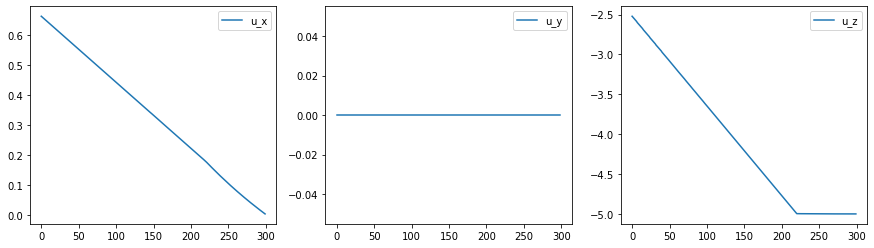

In [119]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(result["u"][0::3], label="u_x")
plt.legend()

plt.subplot(132)
plt.plot(result["u"][1::3], label="u_y")
plt.legend()

plt.subplot(133)
plt.plot(result["u"][2::3], label="u_z")
plt.legend()

plt.show()

In [120]:
dt = 0.1
gravity = 1.62
A = \
np.array([[ 1, 0, 0,dt, 0, 0],
          [ 0, 1, 0, 0,dt, 0],
          [ 0, 0, 1, 0, 0,dt],
          [ 0, 0, 0, 1, 0, 0],
          [ 0, 0, 0, 0, 1, 0],
          [ 0, 0, 0, 0, 0, 1]])

## B
B = \
np.array([[0.5*dt*dt,        0,        0],
          [        0,0.5*dt*dt,        0],
          [        0,        0,0.5*dt*dt],
          [        dt,       0,        0],
          [        0,        dt,       0],
          [        0,        0,       dt]])

## g
g = \
np.array([[                0],
          [                0],
          [0.5*gravity*dt*dt],
          [                0],
          [                0],
          [       gravity*dt]])

state = np.zeros((6,300))
state[:,0] = x_0

for i in range(299):
    state[:,i+1] = np.dot(A, state[:,i]) + np.dot(B, result["u"][3*i:3*i+3]).T + g.T

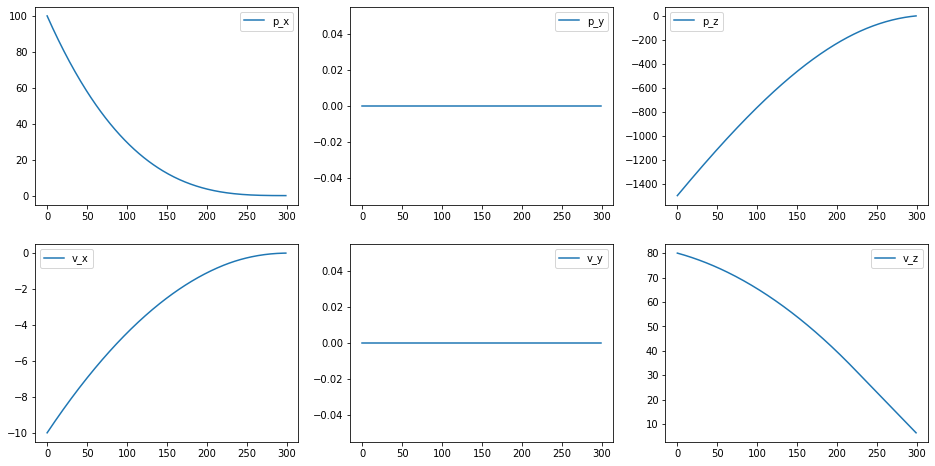

In [121]:
plt.figure(figsize=(16,8))


plt.subplot(231)
plt.plot(state[0,:], label="p_x")
plt.legend()

plt.subplot(232)
plt.plot(state[1,:], label="p_y")
plt.legend()

plt.subplot(233)
plt.plot(state[2,:], label="p_z")
plt.legend()

plt.subplot(234)
plt.plot(state[3,:], label="v_x")
plt.legend()

plt.subplot(235)
plt.plot(state[4,:], label="v_y")
plt.legend()

plt.subplot(236)
plt.plot(state[5,:], label="v_z")
plt.legend()

plt.show()

# Case 2.

In [110]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,20])

upper_boundary = 5.0
downer_boundary = 0.0

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300, max_epoch=50, max_iteration=100)

In [111]:
MECS.solve()

In [112]:
result = MECS.copy_and_unpack_result()

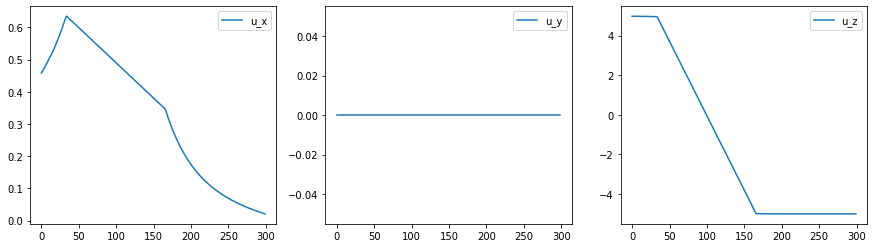

In [113]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(result["u"][0::3], label="u_x")
plt.legend()

plt.subplot(132)
plt.plot(result["u"][1::3], label="u_y")
plt.legend()

plt.subplot(133)
plt.plot(result["u"][2::3], label="u_z")
plt.legend()

plt.show()

In [114]:
dt = 0.1
gravity = 1.62
A = \
np.array([[ 1, 0, 0,dt, 0, 0],
          [ 0, 1, 0, 0,dt, 0],
          [ 0, 0, 1, 0, 0,dt],
          [ 0, 0, 0, 1, 0, 0],
          [ 0, 0, 0, 0, 1, 0],
          [ 0, 0, 0, 0, 0, 1]])

## B
B = \
np.array([[0.5*dt*dt,        0,        0],
          [        0,0.5*dt*dt,        0],
          [        0,        0,0.5*dt*dt],
          [        dt,       0,        0],
          [        0,        dt,       0],
          [        0,        0,       dt]])

## g
g = \
np.array([[                0],
          [                0],
          [0.5*gravity*dt*dt],
          [                0],
          [                0],
          [       gravity*dt]])

state = np.zeros((6,300))
state[:,0] = x_0

for i in range(299):
    state[:,i+1] = np.dot(A, state[:,i]) + np.dot(B, result["u"][3*i:3*i+3]).T + g.T

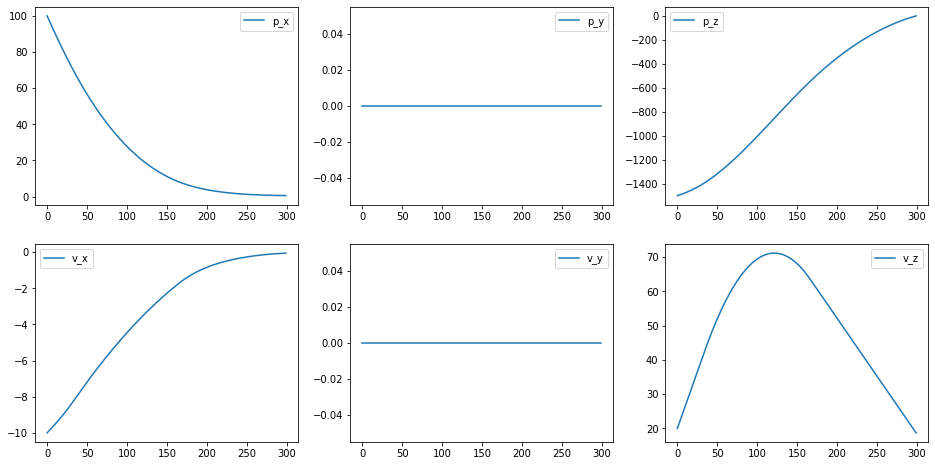

In [115]:
plt.figure(figsize=(16,8))


plt.subplot(231)
plt.plot(state[0,:], label="p_x")
plt.legend()

plt.subplot(232)
plt.plot(state[1,:], label="p_y")
plt.legend()

plt.subplot(233)
plt.plot(state[2,:], label="p_z")
plt.legend()

plt.subplot(234)
plt.plot(state[3,:], label="v_x")
plt.legend()

plt.subplot(235)
plt.plot(state[4,:], label="v_y")
plt.legend()

plt.subplot(236)
plt.plot(state[5,:], label="v_z")
plt.legend()

plt.show()

# Compare

In [31]:
class OptimizerForGuidance:
    def __init__(self, learning_rate, step):
        ## important parameters
        self.axis = 3
        self.DOF  = 6
        
        ## set parameters
        lr_set = (np.ones((self.axis*step)) * learning_rate).astype(np.float32)
        lr_set_byte = lr_set.nbytes
        self.lr_set = cuda.mem_alloc(lr_set_byte)
        cuda.memcpy_htod(self.lr_set, lr_set)
        
        ## kernel function
        self.kernel_function()

    def run(self, theta, gradient, step):
        ## theta, gradient: gpuarray type variable
        self.basic_optimizer(theta,
                             gradient,
                             self.lr_set,
                             block=(3,1,1),
                             grid=(step,1,1))

    def memory_free(self):
        self.lr_set.free()

    def kernel_function(self):
        ## block=(3,1,1), grid=(step,1,1)
        basic_optimizer_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void basic_optimizer(float* theta, float* gradient, float* learning_rate) {

            int index = tx + bx * 3;

            theta[index] -= gradient[index] * learning_rate[index];

            __syncthreads();
        }
        """
        basic_optimizer_ker = SourceModule(basic_optimizer_ker_function)

        ## block=(3,1,1), grid=(step,1,1)
        learning_rate_tuning_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void learning_rate_tuning(float* error_compare, float* learning_rate, int iteration) {

            int index = tx + bx * 3;
            
            if (error_compare[iteration-1] > error_compare[iteration]) {
                learning_rate[index] *= 1.2;
            }
            else {
                learning_rate[index] *= 0.5;
            }

            __syncthreads();
        }
        """
        learning_rate_tuning_ker = SourceModule(learning_rate_tuning_ker_function)

        self.basic_optimizer      = basic_optimizer_ker.get_function("basic_optimizer")
        self.learning_rate_tuning = learning_rate_tuning_ker.get_function("learning_rate_tuning")

In [28]:
class MinimumEnergyControlSolver:
    def __init__(self, x_des, x_0, upper_boundary, downer_boundary, dt=0.1, step=50, max_epoch=100, max_iteration=20):
        ## important constants
        self.axis = 3
        self.DOF  = 6
        self.initial_step = step

        ## step size
        self.step = step

        ## max epoch
        self.max_epoch = max_epoch
        
        ## max iteration
        self.max_iteration = max_iteration

        ## initialize MEC(minimum energy control)
        self.MEC = MinimumEnergyControl(x_des, x_0, dt)

        ## initialize optimizer
        learning_rate = 1e-4

        self.optimizer = OptimizerForGuidance(learning_rate, self.step)

        ## constraint
        self.upper_boundary  = upper_boundary
        self.downer_boundary = downer_boundary

        self.constraint = ConstraintsForInput(self.MEC, self.upper_boundary, self.downer_boundary)

        ## initial kernel size
        self.TPB = int(math.sqrt(step))
        self.iteration = int(math.sqrt(step))

        ## to compare whether break or not
        self.epsilon = 1e-4

################################################################################

    def solve(self):
        ## define problem: fit matrices for left step
        self.define_problem()

        ## iteration
        epoch = 0

        while (epoch < self.max_epoch):
            ## initialize
            iteration = 0

            ## learning rate tuning
            while (iteration < self.max_iteration):

                ## get gradient
                self.MEC.run(self.step)

                ## optimize
                self.optimizer.run(self.MEC.u, self.MEC.gradient, self.step)

                ## tune learning rate
                self.learning_rate_tuning(iteration)

                iteration += 1

            ## constraint
            self.constraint.projection(self.step)

            ## evaluate
            self.evaluate(epoch)

            ## update...
            epoch += 1

        ## update state
        # self.update_state(step)

        ## record data

        ## get next step

################################################################################

    def define_problem(self):
        ## define_problem
        self.MEC.define_problem(self.step)

        ## evaluate
        ## error_vector
        error_vector      = np.zeros((self.DOF + self.axis*self.step)).astype(np.float32)
        error_vector_byte = error_vector.nbytes
        self.error_vector = cuda.mem_alloc(error_vector_byte)
        cuda.memcpy_htod(self.error_vector, error_vector)

        ## error for record
        error      = np.zeros((self.max_iteration)).astype(np.float32)
        error_byte = error.nbytes
        self.error = cuda.mem_alloc(error_byte)
        cuda.memcpy_htod(self.error, error)

        ## compare error for learning rate tuning
        error_compare      = np.zeros((self.max_iteration)).astype(np.float32)
        error_compare[-1]  = np.float32(1e+6)
        error_compare_byte = error_compare.nbytes
        self.error_compare = cuda.mem_alloc(error_compare_byte)
        cuda.memcpy_htod(self.error_compare, error_compare)

        ## for compare
        ## state record
        # state      = np.zeros((self.DOF*self.step)).astype(np.float32)
        # state_byte = state.nbytes
        # self.state = cuda.mem_alloc(state_byte)
        # cuda.memcpy_htod(self.state, state)

        ## control input
        # input      = np.zeros((self.axis*self.step)).astype(np.float32)
        # input_byte = input.nbytes
        # self.input = cuda.mem_alloc(input_byte)
        # cuda.memcpy_htod(self.input, input)

        ## norm of gradient
        norm_of_gradient      = np.zeros((self.max_epoch)).astype(np.float32)
        norm_of_gradient_byte = norm_of_gradient.nbytes
        self.norm_of_gradient = cuda.mem_alloc(norm_of_gradient_byte)
        cuda.memcpy_htod(self.norm_of_gradient, norm_of_gradient)

        ## kernel function
        self.kernel_function()

        ## kernel size
        self.TPB, self.iteration = self.define_optimal_kernel_size(self.axis * self.step)

################################################################################
    
    def define_optimal_kernel_size(self, n):
        thread_per_block = int(math.sqrt(n / 2))
        
        iteration = int(n / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

################################################################################

    def learning_rate_tuning(self, iteration):
        ## get error
        self.calculate_error(iteration)

        ## learning rate tuning
        self.optimizer.learning_rate_tuning(self.error_compare,
                                            self.optimizer.lr_set,
                                            np.int32(iteration),
                                            block=(self.axis,1,1),
                                            grid=(self.step,1,1))

    def calculate_error(self, iteration):

        ## set size
        block_size = self.step + 2
        grid_size  = self.axis * self.step + self.DOF

        ## evaluate learning
        self.get_error_vector(self.MEC.G,
                              self.MEC.rho_matrix,
                              self.MEC.u,
                              self.MEC.C,
                              self.iteration,
                              self.error_vector,
                              block=(self.TPB,1,1),
                              grid=(grid_size,1,1))
        
        self.get_vector_norm(self.error_vector,
                             self.error_compare,
                             np.int32(iteration),
                             block=(block_size,1,1),
                             grid=(1,1,1))

################################################################################

    def evaluate(self, epoch):
        ## get norm of gradient
        self.calculate_norm_of_gradient(epoch)

        ## compare with epsilon
        norm_of_gradient = np.zeros((self.max_epoch)).astype(np.float32)
        cuda.memcpy_dtoh(norm_of_gradient, self.norm_of_gradient)

        if norm_of_gradient[epoch] < self.epsilon:
            return True

        else:
            return False

    def calculate_norm_of_gradient(self, epoch):

        ## set size
        block_size = self.step + 2
            
        self.get_vector_norm(self.MEC.gradient,
                             self.norm_of_gradient,
                             np.int32(epoch),
                             block=(block_size,1,1),
                             grid=(1,1,1))

################################################################################

    def update_state(self, step):
        ## update state
        self.get_next_state(self.MEC.x_current,
                            self.MEC.u,
                            self.MEC.dt,
                            self.MEC.gravity_matrix,
                            self.state,
                            np.int32(step),
                            block=(6,1,1),
                            grid=(1,1,1))

################################################################################

    def memory_free(self):
        pass

    def memory_freeall(self):

        try:
            self.MEC.memory_freeall()
            self.optimizer.memory_free()

        except:
            pass

        self.error_vector.free()
        self.error.free()
        self.error_compare.free()
        self.norm_of_gradient.free()
        # self.state.free()

################################################################################

    def kernel_function(self):
        ## block=(TPB,1,1), grid=(DOF+axis*step,1,1)
        get_error_vector_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_error_vector(float* G, float* rho_matrix, float* u, float* C, int iteration, float* error_vector) {
            
            if (bx < 6) {
                __shared__ float value[1000];

                value[tx] = 0.0;

                __syncthreads();

                for (int i = 0; i <iteration; i++) {
                    int index1 = i + tx * iteration;
                    int index2 = index1 * 6 + bx;

                    value[tx] += G[index2] * u[index1];
                }

                __syncthreads();

                if (tx == 0) {
                    value[1000] = 0.0;

                    for (int j = 0; j < bs; j++) {
                        value[1000] += value[j];
                    }

                    error_vector[bx] = value[1000] - C[bx];
                }
            }
            else {
                if (tx == 0) {
                    int index1 = bx - 6;
                    int index2 = gs - 5;
                    int index3 = index1 * index2;

                    error_vector[bx] = rho_matrix[index3] * u[index1];
                }

                __syncthreads();
            }
        }
        """
        get_error_vector_ker = SourceModule(get_error_vector_ker_function)

        ## block=(step+2,1,1), grid=(1,1,1)
        get_vector_norm_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void get_vector_norm(float* vector, float* vector_norm, int index) {

            __shared__ float value[1000];

            int index1 = tx * 3;

            for (int i = 0; i < 3; i++) {
                value[index1+i] = vector[index1+i];
            }

            __syncthreads();

            if (tx == 0) {
                int length = bs * 3;

                vector_norm[index] = get_norm(value, length);
            }

            __syncthreads();
        }
        """
        get_vector_norm_ker = SourceModule(get_vector_norm_ker_function)

        ## block=(6,1,1), grid=(1,1,1)
        # get_next_state_ker_function = \
        # """
        # #define tx (threadIdx.x)

        # __global__ void get_next_state(float* x, float* u, float dt, float* gravity_matrix, float* state, int step) {

        #     __shared__ float momentum[6];
        #     __shared__ float control[6];
        #     __shared__ float gravity[6];

        #     int index1 = tx + step * 6;
        #     // int index2 = tx + step * 3;
        #     int index3 = tx % 3;

        #     if (tx < 3) {

        #         momentum[tx] = x[tx] + dt * x[tx+3];
        #         control[tx]  = 0.5*dt*dt * u[index3];

        #         if (index3 == 2) {
        #             gravity[tx] = gravity_matrix[tx];
        #         }
        #         else {
        #             gravity[tx] = 0.0;
        #         }

        #         // input[index2] = u[index3]; 
        #     }
        #     else {

        #         momentum[tx] = x[tx];
        #         control[tx]  = dt * u[index3];

        #         if (index3 == 2) {
        #             gravity[tx] = gravity_matrix[tx];
        #         }
        #         else {
        #             gravity[tx] = 0.0;
        #         }
        #     }

        #     __syncthreads();

        #     x[tx] = momentum[tx] + control[tx] + gravity[tx];
        #     state[index1] = x[tx];

        #     __syncthreads();
        # }
        # """
        # get_next_state_ker = SourceModule(get_next_state_ker_function)

        self.get_error_vector     = get_error_vector_ker.get_function("get_error_vector")
        self.get_vector_norm            = get_vector_norm_ker.get_function("get_vector_norm")
        # self.get_next_state     = get_next_state_ker.get_function("get_next_state")

################################################################################

    def copy_and_unpack_result(self):
        
        ## unpack matrix
        try:
            matrices = self.MEC.copy_and_unpack_result(self.step)
        except:
            matrices = dict()

        ## copy error
        error = np.empty((self.max_iteration)).astype(np.float32)
        cuda.memcpy_dtoh(error, self.error)

        ## copy error_vector
        error_vector = np.empty((self.DOF + self.axis * self.step)).astype(np.float32)
        cuda.memcpy_dtoh(error_vector, self.error_vector)

        ## copy norm of gradient
        norm_of_gradient = np.empty((self.max_epoch)).astype(np.float32)
        cuda.memcpy_dtoh(norm_of_gradient, self.norm_of_gradient)

        ## copy state
        # state = np.empty((self.DOF*self.initial_step)).astype(np.float32)
        # cuda.memcpy_dtoh(state, self.state)

        ## copy input
        # input= np.empty((self.axis*self.initial_step)).astype(np.float32)
        # cuda.memcpy_dtoh(input, self.input)

        ## pack data
        matrices["error"] = error.reshape(self.max_iteration)
        matrices["error_vector"] = error_vector.reshape(self.DOF + self.axis*self.step,1)
        matrices["norm_of_gradient"] = norm_of_gradient.reshape(1, self.max_epoch)
        # matrices["state"] = state.reshape(self.initial_step,self.DOF).T
        # matrices["input"] = input.reshape(self.initial_step,self.axis).T

        ## delete all memory
        self.memory_freeall()

        return matrices

In [32]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

upper_boundary = 5.0
downer_boundary = 0.0

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300, max_epoch=50, max_iteration=100)

In [33]:
MECS.solve()

In [34]:
result = MECS.copy_and_unpack_result()

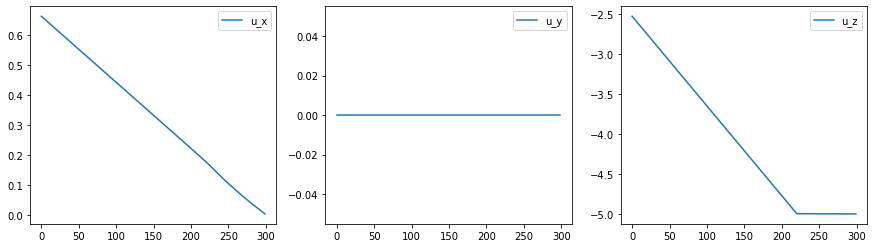

In [35]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.plot(result["u"][0::3], label="u_x")
plt.legend()

plt.subplot(132)
plt.plot(result["u"][1::3], label="u_y")
plt.legend()

plt.subplot(133)
plt.plot(result["u"][2::3], label="u_z")
plt.legend()

plt.show()

# Test